Let's import Keras, as well as change our backend to plaidml to use the internal GPU on my Macbook. 

In [1]:
import os
import keras  
import numpy as np 
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

Using TensorFlow backend.


# Loading the Data 

Note:  If you get strange errors, a total "Restart Kernel and Run All" may work wonders. 

In [2]:
from keras.datasets import imdb
load_old = np.load
np.load = lambda *a,**kw: load_old(*a,allow_pickle=True,**kw)


(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

Let's take a look at the first sample of the training data. 

In [45]:
# train_data[0]

# Background

The `train_data` and `test_data` are lists of reviews, with words encoded as integers mapping to words in a dictionary.  This is **binary classification** - the labels are 0 for *negative* reviews and 1 for *positive* reviews. 

# Preparation

We have lists of integers, and we can't feed these to the neural network.  They have different lengths, and that's just not going to work.  We have to choices. 

1. Pad our lists to all have the same length
2. One hot encode to change sequences of word indices - say [1, 5, 3] - into 1s and 0s. 

We will take the One Hot Encoding approach in this walkthrough. 

Let's do it manually, so we understand exactly what's going on here. 

In [4]:
import numpy as np

# Define a function to encode/vectorize - one hot encoding. 


def vectorize_sequences(sequences, dimension=10000):
    # Initialize the results equal to a matrix of all zeroes, with the rows being the amount of word_indices provided and the columns being the dimensions, or the samples
    results = np.zeros((len(sequences), dimension))
    # Set the indices which have words at them equal to 1
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

Let's take a look at one sample. 

In [5]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

As we can see, we are now representing word indices from the most common 10,000 words as ones and zeroes.

Let's also vectorize the labels. 

In [6]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

# Sculpt

Our input data is vectors and our labels scalars.  For this type of network, we can use a simple `Dense` setup with `relu` activations. 

In [9]:
from tensorflow.keras import layers 
from tensorflow.keras import models 

# Construct the model
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile

We will use the `binary_crossentropy` loss function.  Let's break that down.  
* Binary - one of two outcomes, and this problem has been broken into a binary classfication 
* Crossentropy - measures the distance between probability distributions and predictions

We will also use `rmsprops` as our optimizer.  Generally, you can be safe with this one.  It does the following: 
* Balances step size and momentum 
* Avoids exploding with large gradients
* Avoids vanishing with small gradients 

In [10]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy',
              metrics=['accuracy'])

If we wanted to **configure certain parameters** for our parameters, such as a different learning rate for our optimizer, we can **construct class instances** and pass the parameters of interest to the constructor. 

In [16]:
from tensorflow.keras import optimizers
from tensorflow.keras import losses 
from tensorflow.keras import metrics 

model.compile(optimizer=optimizers.RMSprop(learning_rate = 0.001),
              loss=losses.binary_crossentropy, metrics = [metrics.binary_accuracy])

# Validate

Let's create a validation set as our model has never seen this data before

In [18]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

# Train!

Let's train the data!  Remove the semi-colon to see it in action. 

In [20]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val));

Epoch 1/20
30/30 [==============================] - 1s 31ms/step - loss: 0.0052 - binary_accuracy: 0.9990 - val_loss: 0.7537 - val_binary_accuracy: 0.8636
Epoch 2/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0018 - binary_accuracy: 0.9999 - val_loss: 0.8685 - val_binary_accuracy: 0.8550
Epoch 3/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0063 - binary_accuracy: 0.9982 - val_loss: 0.8317 - val_binary_accuracy: 0.8621
Epoch 4/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0011 - binary_accuracy: 0.9999 - val_loss: 0.8610 - val_binary_accuracy: 0.8612
Epoch 5/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0051 - binary_accuracy: 0.9985 - val_loss: 0.9045 - val_binary_accuracy: 0.8613
Epoch 6/20
30/30 [==============================] - 0s 12ms/step - loss: 7.3215e-04 - binary_accuracy: 0.9999 - val_loss: 0.9046 - val_binary_accuracy: 0.8615
Epoch 7/20
30/30 [==============================] - 0s 13ms/step -

This returns a `History` object containing a `history` dictionary.  This dictionary holds everything we need to know about how our training went.  Let's take a look.

Uncomment the `pprint` function to see the contents of the dictionary

In [38]:
from pprint import pprint 
history_dict = history.history 
# pprint(history_dict)

Let's plot. 

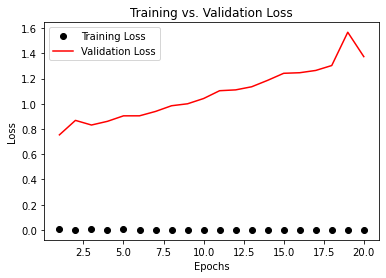

In [36]:
import matplotlib.pyplot as plt 

history_dict = history.history 
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['binary_accuracy']
# We do this so that our first epoch is epoch 1, not epoch 0
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss_values, 'ko', label = 'Training Loss');
plt.plot(epochs, val_loss_values, 'r', label = 'Validation Loss');
plt.title('Training vs. Validation Loss');
plt.xlabel('Epochs');
plt.ylabel('Loss');
plt.legend();
plt.show()

Okay, what's going on here?  Classific overfitting, that's what! 

Let's retrain over less epochs to prevent this.

In [39]:
model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val));

Epoch 1/20
30/30 [==============================] - 1s 24ms/step - loss: 2.7320e-05 - binary_accuracy: 1.0000 - val_loss: 1.3864 - val_binary_accuracy: 0.8566
Epoch 2/20
30/30 [==============================] - 0s 12ms/step - loss: 2.0478e-05 - binary_accuracy: 1.0000 - val_loss: 1.4026 - val_binary_accuracy: 0.8561
Epoch 3/20
30/30 [==============================] - 0s 12ms/step - loss: 1.5313e-05 - binary_accuracy: 1.0000 - val_loss: 1.4539 - val_binary_accuracy: 0.8564
Epoch 4/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0013 - binary_accuracy: 0.9995 - val_loss: 1.5084 - val_binary_accuracy: 0.8554
Epoch 5/20
30/30 [==============================] - 0s 12ms/step - loss: 8.9649e-06 - binary_accuracy: 1.0000 - val_loss: 1.5088 - val_binary_accuracy: 0.8570
Epoch 6/20
30/30 [==============================] - 0s 12ms/step - loss: 7.8590e-06 - binary_accuracy: 1.0000 - val_loss: 1.5169 - val_binary_accuracy: 0.8560
Epoch 7/20
30/30 [==============================] 

# Evaluation

In [41]:
model.evaluate(x_test, y_test)

782/782 [==============================] - 1s 809us/step - loss: 1.9299 - binary_accuracy: 0.8415


[1.9299476146697998, 0.841480016708374]

We're still overfitting unfortunately.  Nevertheless, 84% accuracy for this approach ain't bad! 

# Predictions

To predict on actual values, just pass in the values to `model.predict()`

In [44]:
# Remove the semi-colon to see predictions
model.predict(x_test);

# Improving/Reevaluating

What steps could we take to improve this?  There are various, but for now, let's content ourselves with the author's ideas: 
* Change the amount of hidden units 
* Use a different loss function - MSE, for instance
* Use a different activation function - perhaps $tanh$


In [ ]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../../static/jupyter-styles/custom.css", "r").read()
    return HTML(styles)
css_styling()